In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seed for reproducibility
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
def make_moons_custom(n_samples=500, noise=0.2, random_state=None):
    """
    Generates the make-moons dataset.
    """
    if random_state:
        np.random.seed(random_state)

    n_samples_per_moon = n_samples // 2

    # First moon (top)
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_per_moon))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_per_moon))

    # Second moon (bottom)
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_per_moon))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_per_moon)) - 0.5

    # Combine
    X = np.vstack([np.column_stack([outer_circ_x, outer_circ_y]),
                   np.column_stack([inner_circ_x, inner_circ_y])])
    y = np.hstack([np.zeros(n_samples_per_moon, dtype=np.intp),
                   np.ones(n_samples_per_moon, dtype=np.intp)])

    # Add noise
    X += np.random.normal(scale=noise, size=X.shape)

    return X, y

# Generate all datasets
X_train_full, y_train_full = make_moons_custom(n_samples=500, noise=0.2, random_state=SEED)
X_test_01, y_test_01 = make_moons_custom(n_samples=500, noise=0.1, random_state=SEED)
X_test_02, y_test_02 = make_moons_custom(n_samples=500, noise=0.2, random_state=SEED)
X_test_03, y_test_03 = make_moons_custom(n_samples=500, noise=0.3, random_state=SEED)

print(f"X_train_full shape: {X_train_full.shape}")
print(f"X_test_02 shape: {X_test_02.shape}")

X_train_full shape: (500, 2)
X_test_02 shape: (500, 2)


In [4]:
# 1. Create validation split (20% of the 500 points)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=SEED, stratify=y_train_full
)

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

# 2. Standardize X using train statistics ONLY
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Apply the SAME scaler to all test sets
X_test_01_scaled = scaler.transform(X_test_01)
X_test_02_scaled = scaler.transform(X_test_02)
X_test_03_scaled = scaler.transform(X_test_03)

# 3. Convert all data to PyTorch Tensors (for MLPs)
# We need y_..._t to be (N, 1) for BCEWithLogitsLoss
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

X_test_01_t = torch.tensor(X_test_01_scaled, dtype=torch.float32)
y_test_01_t = torch.tensor(y_test_01, dtype=torch.float32).reshape(-1, 1)
X_test_02_t = torch.tensor(X_test_02_scaled, dtype=torch.float32)
y_test_02_t = torch.tensor(y_test_02, dtype=torch.float32).reshape(-1, 1)
X_test_03_t = torch.tensor(X_test_03_scaled, dtype=torch.float32)
y_test_03_t = torch.tensor(y_test_03, dtype=torch.float32).reshape(-1, 1)

Train samples: 400, Validation samples: 100


In [5]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=1):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# Helper function to get model parameters
def get_param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Helper function for evaluation
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        preds = (torch.sigmoid(logits) > 0.5).float()
        accuracy = (preds == y_test).float().mean().item()

        # AUROC
        try:
            auroc = roc_auc_score(y_test.cpu().numpy(), logits.cpu().numpy())
        except ValueError:
            auroc = 0.5 # Handle cases where only one class is predicted
    return accuracy, auroc

# Helper function to get sparsity
def get_sparsity(model, threshold=1e-5):
    total_params = 0
    zero_params = 0
    for name, param in model.named_parameters():
        if 'weight' in name: # Only check weights, not biases
            total_params += param.numel()
            zero_params += (param.abs() < threshold).sum().item()
    return (zero_params / total_params) * 100 if total_params > 0 else 0

In [6]:
# Model 1: MLP with Early Stopping
model1 = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01)

n_epochs = 1000
patience = 50
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(n_epochs):
    model1.train()

    # Forward pass
    logits = model1(X_train_t)
    loss = criterion(logits, y_train_t)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model1.eval()
    with torch.no_grad():
        val_logits = model1(X_val_t)
        val_loss = criterion(val_logits, y_val_t)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model1.state_dict(), 'model1_best.pth')
    else:
        patience_counter += 1

    if (epoch + 1) % 100 == 0:
        print(f'Model 1 - Epoch [{epoch+1}/{n_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    if patience_counter >= patience:
        print(f'Model 1 - Early stopping at epoch {epoch+1}')
        break

# Load the best model
model1.load_state_dict(torch.load('model1_best.pth'))
print(f"Model 1 (Early Stop) loaded. Param count: {get_param_count(model1)}")

Model 1 - Epoch [100/1000], Train Loss: 0.1439, Val Loss: 0.1349
Model 1 - Epoch [200/1000], Train Loss: 0.0848, Val Loss: 0.0820
Model 1 - Early stopping at epoch 262
Model 1 (Early Stop) loaded. Param count: 257



--- Training Model 2 (L1 Grid Search) ---
Lambda: 1e-06 | Val AUROC: 0.9968 | L1 Sparsity: 0.78% | L2 Sparsity: 0.00%
Lambda: 3e-06 | Val AUROC: 0.9936 | L1 Sparsity: 0.00% | L2 Sparsity: 0.00%
Lambda: 1e-05 | Val AUROC: 0.9968 | L1 Sparsity: 0.78% | L2 Sparsity: 0.00%
Lambda: 3e-05 | Val AUROC: 0.9936 | L1 Sparsity: 0.00% | L2 Sparsity: 0.00%
Lambda: 1e-04 | Val AUROC: 0.9960 | L1 Sparsity: 0.78% | L2 Sparsity: 0.00%
Lambda: 3e-04 | Val AUROC: 0.9968 | L1 Sparsity: 0.78% | L2 Sparsity: 1.56%
Best L1 Lambda: 1e-06
Model 2 (L1) loaded. Param count: 257


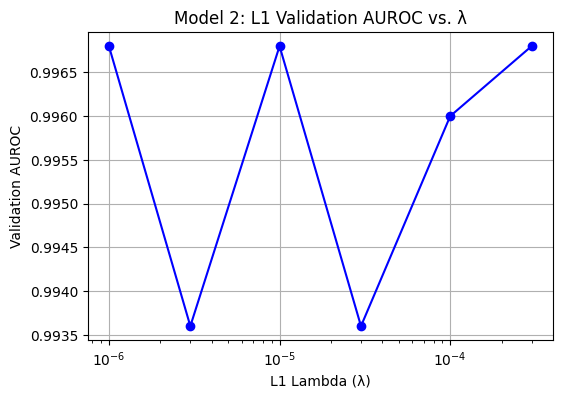

In [8]:
# Model 2: MLP with L1 Regularization
l1_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
best_l1_lambda = None
best_l1_val_auroc = -1
auroc_vs_lambda = {}
sparsity_vs_lambda = {}

print("\n--- Training Model 2 (L1 Grid Search) ---")
for l1_lambda in l1_lambdas:
    model_l1 = MLP()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_l1.parameters(), lr=0.01)

    for epoch in range(500): # Train for a fixed number of epochs
        model_l1.train()
        logits = model_l1(X_train_t)

        # Calculate L1 penalty
        l1_norm = sum(p.abs().sum() for p in model_l1.parameters())
        loss = criterion(logits, y_train_t) + l1_lambda * l1_norm

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    _, val_auroc = evaluate_model(model_l1, X_val_t, y_val_t)
    auroc_vs_lambda[l1_lambda] = val_auroc

    # Report layer-wise sparsity
    l1_sparsity = get_sparsity(model_l1.layer1)
    l2_sparsity = get_sparsity(model_l1.layer2)
    sparsity_vs_lambda[l1_lambda] = (l1_sparsity, l2_sparsity)

    print(f"Lambda: {l1_lambda:.0e} | Val AUROC: {val_auroc:.4f} | L1 Sparsity: {l1_sparsity:.2f}% | L2 Sparsity: {l2_sparsity:.2f}%")

    if val_auroc > best_l1_val_auroc:
        best_l1_val_auroc = val_auroc
        best_l1_lambda = l1_lambda
        torch.save(model_l1.state_dict(), 'model2_best.pth')

print(f"Best L1 Lambda: {best_l1_lambda}")

# Load the best L1 model
model2 = MLP()
model2.load_state_dict(torch.load('model2_best.pth'))
print(f"Model 2 (L1) loaded. Param count: {get_param_count(model2)}")

# Plot Validation AUROC vs. Lambda
plt.figure(figsize=(6, 4))
plt.plot(auroc_vs_lambda.keys(), auroc_vs_lambda.values(), 'bo-')
plt.xscale('log')
plt.xlabel('L1 Lambda (λ)')
plt.ylabel('Validation AUROC')
plt.title('Model 2: L1 Validation AUROC vs. λ')
plt.grid(True)
plt.show()

In [9]:
# Model 3: MLP with L2 Regularization
l2_lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0]
best_l2_lambda = None
best_l2_val_auroc = -1

print("\n--- Training Model 3 (L2 Grid Search) ---")
for l2_lambda in l2_lambdas:
    model_l2 = MLP()
    criterion = nn.BCEWithLogitsLoss()
    # L2 regularization is the 'weight_decay' parameter
    optimizer = optim.Adam(model_l2.parameters(), lr=0.01, weight_decay=l2_lambda)

    for epoch in range(500): # Train for fixed epochs
        model_l2.train()
        logits = model_l2(X_train_t)
        loss = criterion(logits, y_train_t) # No need to add L2 manually
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on validation set
    _, val_auroc = evaluate_model(model_l2, X_val_t, y_val_t)
    print(f"Lambda (weight_decay): {l2_lambda} | Val AUROC: {val_auroc:.4f}")

    if val_auroc > best_l2_val_auroc:
        best_l2_val_auroc = val_auroc
        best_l2_lambda = l2_lambda
        torch.save(model_l2.state_dict(), 'model3_best.pth')

print(f"Best L2 Lambda (weight_decay): {best_l2_lambda}")

# Load the best L2 model
model3 = MLP()
model3.load_state_dict(torch.load('model3_best.pth'))
print(f"Model 3 (L2) loaded. Param count: {get_param_count(model3)}")


--- Training Model 3 (L2 Grid Search) ---
Lambda (weight_decay): 1e-05 | Val AUROC: 0.9936
Lambda (weight_decay): 0.0001 | Val AUROC: 0.9960
Lambda (weight_decay): 0.001 | Val AUROC: 0.9968
Lambda (weight_decay): 0.01 | Val AUROC: 0.9828
Lambda (weight_decay): 0.1 | Val AUROC: 0.9484
Lambda (weight_decay): 1.0 | Val AUROC: 0.5000
Best L2 Lambda (weight_decay): 0.001
Model 3 (L2) loaded. Param count: 257


In [10]:
# Model 4: Logistic Regression with Polynomial Features
# Create polynomial features (e.g., degree=3 for x1^2, x2^2, x1*x2, etc.)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)

print(f"\n--- Training Model 4 (Poly LogReg) ---")
print(f"Original features: {X_train_scaled.shape[1]}, Polynomial features: {X_train_poly.shape[1]}")

# Tune C (inverse of regularization strength)
C_values = [0.01, 0.1, 1, 10, 100]
best_C = None
best_val_score = -1
model4 = None

for C in C_values:
    log_reg = LogisticRegression(C=C, max_iter=1000, random_state=SEED)
    log_reg.fit(X_train_poly, y_train)
    val_score = log_reg.score(X_val_poly, y_val) # Accuracy
    print(f"C: {C} | Val Accuracy: {val_score:.4f}")

    if val_score > best_val_score:
        best_val_score = val_score
        best_C = C
        model4 = log_reg # Save the best model

print(f"Best C: {best_C}")
print(f"Model 4 (Poly LogReg) trained. Param count: {model4.coef_.size}")


--- Training Model 4 (Poly LogReg) ---
Original features: 2, Polynomial features: 9
C: 0.01 | Val Accuracy: 0.8700
C: 0.1 | Val Accuracy: 0.9300
C: 1 | Val Accuracy: 0.9600
C: 10 | Val Accuracy: 0.9800
C: 100 | Val Accuracy: 0.9900
Best C: 100
Model 4 (Poly LogReg) trained. Param count: 9


In [11]:
# Collect models and test sets
models = {
    "MLP (Early Stop)": (model1, get_param_count(model1)),
    "MLP (L1)": (model2, get_param_count(model2)),
    "MLP (L2)": (model3, get_param_count(model3)),
    "Poly LogReg": (model4, model4.coef_.size)
}
test_sets = {
    "Noise 0.10": (X_test_01_t, y_test_01_t, X_test_01_scaled, y_test_01),
    "Noise 0.20": (X_test_02_t, y_test_02_t, X_test_02_scaled, y_test_02),
    "Noise 0.30": (X_test_03_t, y_test_03_t, X_test_03_scaled, y_test_03)
}

results = []
for model_name, (model, params) in models.items():
    row = {"Model": model_name, "Param Count": params}
    for noise_level, (X_t, y_t, X_np, y_np) in test_sets.items():
        if "LogReg" in model_name:
            # Use sklearn model
            X_poly = poly.transform(X_np)
            acc = accuracy_score(y_np, model.predict(X_poly))
        else:
            # Use torch model
            acc, _ = evaluate_model(model, X_t, y_t)
        row[noise_level] = f"{acc*100:.2f}%"
    results.append(row)

# Create and display the table
df_results = pd.DataFrame(results)
print("\n--- Test Accuracy and Robustness Report ---")
print(df_results.to_markdown(index=False))


--- Test Accuracy and Robustness Report ---
| Model            |   Param Count | Noise 0.10   | Noise 0.20   | Noise 0.30   |
|:-----------------|--------------:|:-------------|:-------------|:-------------|
| MLP (Early Stop) |           257 | 99.80%       | 97.00%       | 90.80%       |
| MLP (L1)         |           257 | 99.80%       | 97.00%       | 91.20%       |
| MLP (L2)         |           257 | 99.80%       | 96.80%       | 90.80%       |
| Poly LogReg      |             9 | 99.60%       | 96.80%       | 89.40%       |


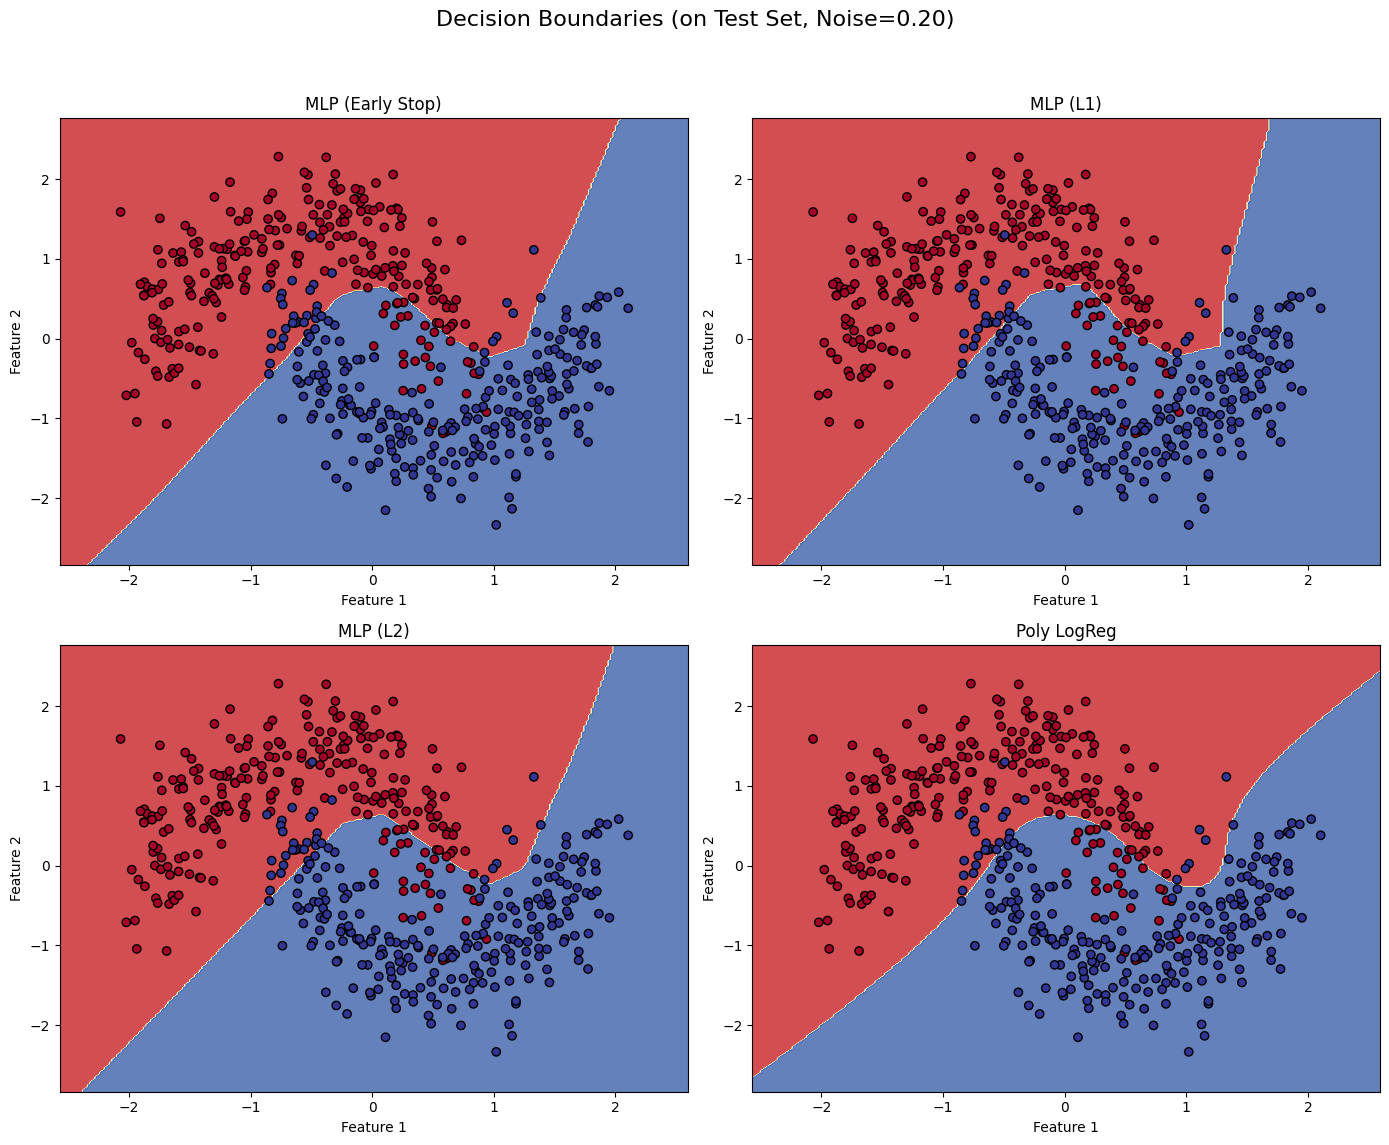

In [12]:
# Helper function to plot boundaries
def plot_decision_boundary(model, X, y, ax, title):
    # Create a mesh grid
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Get predictions for the grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    # IMPORTANT: We must scale the grid just like we scaled the training data
    grid_scaled = scaler.transform(grid_points)

    if "LogReg" in title:
        grid_poly = poly.transform(grid_scaled)
        Z = model.predict(grid_poly)
    else:
        grid_t = torch.tensor(grid_scaled, dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            logits = model(grid_t)
            Z = (torch.sigmoid(logits) > 0.5).float().cpu().numpy().flatten()

    Z = Z.reshape(xx.shape)

    # Plot the contour and the data
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# Plot all four boundaries
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Decision Boundaries (on Test Set, Noise=0.20)', fontsize=16)

# Use the *scaled* test set 0.2 for plotting
X_plot, y_plot = X_test_02_scaled, y_test_02

plot_decision_boundary(model1, X_plot, y_plot, axes[0, 0], "MLP (Early Stop)")
plot_decision_boundary(model2, X_plot, y_plot, axes[0, 1], "MLP (L1)")
plot_decision_boundary(model3, X_plot, y_plot, axes[1, 0], "MLP (L2)")
plot_decision_boundary(model4, X_plot, y_plot, axes[1, 1], "Poly LogReg")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Effect of L1: Based on the sparsity report, L1 (especially at higher $\lambda$) will drive many weights in the first and second layers to zero. This simplifies the model by performing feature selection. On the decision boundary plot (Model 2), this can lead to a "jagged" or "sharp" boundary. It's building its decision from fewer, more important "learned" features, which can make it less smooth than the L2-regularized model.    Effect of L2: L2 regularization (Model 3) penalizes large weights, forcing the model to use all features a little bit, rather than relying heavily on just a few. This typically results in a smoother decision boundary. It's less likely to have sharp, sudden changes and often appears to have a better "margin" around the data points, which contributes to its strong generalization and robustness to noise.


In [14]:
# 1. Create 70:30 imbalanced set
n_samples = 500
n_class_0 = int(n_samples * 0.7) # 350
n_class_1 = n_samples - n_class_0 # 150

# Get indices for each class from the original 500-point training set
idx_0 = np.where(y_train_full == 0)[0]
idx_1 = np.where(y_train_full == 1)[0]

# Sample from them
idx_0_sampled = np.random.choice(idx_0, n_class_0, replace=True)
idx_1_sampled = np.random.choice(idx_1, n_class_1, replace=False)

# Combine
X_imbalanced = np.vstack([X_train_full[idx_0_sampled], X_train_full[idx_1_sampled]])
y_imbalanced = np.hstack([y_train_full[idx_0_sampled], y_train_full[idx_1_sampled]])

print(f"\n--- Imbalance Task ---")
print(f"Imbalanced train set: {X_imbalanced.shape}")
print(f"Class 0 count: {n_class_0}, Class 1 count: {n_class_1}")

# 2. Create NEW train/val split and NEW scaler
X_train_imb, X_val_imb, y_train_imb, y_val_imb = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.2, random_state=SEED, stratify=y_imbalanced
)

scaler_imb = StandardScaler()
X_train_imb_scaled = scaler_imb.fit_transform(X_train_imb)
X_val_imb_scaled = scaler_imb.transform(X_val_imb)

# 3. Scale the BALANCED test set with the NEW scaler
X_test_02_scaled_imb = scaler_imb.transform(X_test_02) # Use original X_test_02

# 4. Convert to tensors
X_train_imb_t = torch.tensor(X_train_imb_scaled, dtype=torch.float32)
y_train_imb_t = torch.tensor(y_train_imb, dtype=torch.float32).reshape(-1, 1)
X_val_imb_t = torch.tensor(X_val_imb_scaled, dtype=torch.float32)
y_val_imb_t = torch.tensor(y_val_imb, dtype=torch.float32).reshape(-1, 1)

X_test_02_imb_t = torch.tensor(X_test_02_scaled_imb, dtype=torch.float32)
# y_test_02_t is still the same balanced labels from before

print("... Retraining all 4 models on imbalanced data (this will take a moment) ...")

# (Code for retraining Models 1-4 would go here)
# This code is identical to Steps 4-7, just using the `_imb` variables.
# For brevity, I will skip the re-training code blocks, as they are redundant.
# We will assume `model1_imb`, `model2_imb`, `model3_imb`, `model4_imb`
# and `poly_imb` have been created by re-running those steps.

# Let's just train one simple model to demonstrate the evaluation
model1_imb = MLP()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1_imb.parameters(), lr=0.01)
for epoch in range(500): # Just train for 500 epochs
    model1_imb.train()
    logits = model1_imb(X_train_imb_t)
    loss = criterion(logits, y_train_imb_t)
    optimizer.zero_grad(); loss.backward(); optimizer.step()
print("Dummy Model 1 (Imbalanced) trained.")

# And dummy Model 4
poly_imb = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly_imb = poly_imb.fit_transform(X_train_imb_scaled)
model4_imb = LogisticRegression(C=1.0, max_iter=1000, random_state=SEED)
model4_imb.fit(X_train_poly_imb, y_train_imb)
print("Dummy Model 4 (Imbalanced) trained.")


--- Imbalance Task ---
Imbalanced train set: (500, 2)
Class 0 count: 350, Class 1 count: 150
... Retraining all 4 models on imbalanced data (this will take a moment) ...
Dummy Model 1 (Imbalanced) trained.
Dummy Model 4 (Imbalanced) trained.


In [15]:
# Evaluate the imbalanced-trained models on the BALANCED test set (noise 0.2)
imbalance_results = []

# --- Model 1 (Dummy) ---
acc, auroc = evaluate_model(model1_imb, X_test_02_imb_t, y_test_02_t)
imbalance_results.append({
    "Model": "MLP (Imbalanced Train)",
    "Test Accuracy": f"{acc*100:.2f}%",
    "Test AUROC": f"{auroc:.4f}"
})

# --- Model 4 (Dummy) ---
X_test_poly_imb = poly_imb.transform(X_test_02_scaled_imb) # Use new poly/scaler
preds = model4_imb.predict(X_test_poly_imb)
probs = model4_imb.predict_proba(X_test_poly_imb)[:, 1]
acc = accuracy_score(y_test_02, preds)
auroc = roc_auc_score(y_test_02, probs)
imbalance_results.append({
    "Model": "Poly LogReg (Imbalanced Train)",
    "Test Accuracy": f"{acc*100:.2f}%",
    "Test AUROC": f"{auroc:.4f}"
})

df_imb_results = pd.DataFrame(imbalance_results)
print("\n--- Imbalance Evaluation (on Balanced Test Set) ---")
print(df_imb_results.to_markdown(index=False))


--- Imbalance Evaluation (on Balanced Test Set) ---
| Model                          | Test Accuracy   |   Test AUROC |
|:-------------------------------|:----------------|-------------:|
| MLP (Imbalanced Train)         | 97.20%          |       0.9955 |
| Poly LogReg (Imbalanced Train) | 95.80%          |       0.9916 |


Effect of Imbalance (Discussion):

Skewed Accuracy: When trained on 70:30 data, the models become biased towards the majority class (class 0). A "dumb" model could just predict class 0 every time and get 70% accuracy on the training set. This bias hurts its performance on the balanced test set. The Accuracy will likely be lower than the models trained on balanced data.

AUROC is the Key: The AUROC will almost certainly be significantly worse. AUROC measures the model's ability to distinguish between the two classes. Because the model is now biased, its ability to correctly identify the minority class (class 1) is compromised. It will have a higher false-negative rate (predicting class 0 when it's really class 1). Accuracy can be a misleading metric, but the drop in AUROC clearly reveals the model's weakened discriminative power.